# NOF communication protocol implementing the spectral clustering algorithm with the spectral sparsification technique

In [1]:
using ScikitLearn
using PyPlot, Random, Statistics, LinearAlgebra
using Laplacians
@sk_import datasets: (make_circles, make_moons, make_blobs)
@sk_import cluster: (KMeans)
@sk_import neighbors: kneighbors_graph

┌ Info: Recompiling stale cache file /home/fabricio/.julia/compiled/v1.1/ScikitLearn/tbUuI.ji for ScikitLearn [3646fa90-6ef7-5e7e-9f22-8aca16db6324]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/fabricio/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/fabricio/.julia/compiled/v1.1/Laplacians/poVbr.ji for Laplacians [6f8e5838-0efe-5de0-80a3-5fb4f8dbb1de]
└ @ Base loading.jl:1184


PyObject <function kneighbors_graph at 0x7fd1c424c950>

In [2]:
colors0 = collect("bgrcmykbgrcmykbgrcmykbgrcmyk")
colors = vcat(fill(colors0, 20)...)
markers = ["o", "*"]

2-element Array{String,1}:
 "o"
 "*"

In [3]:
#recieve a set of points and return an adjacency matrix
function get_adjacency_matrix2(X, neighbors)
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=neighbors, include_self=false).todense() # PyCall does not support numpy sparse matrices
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity')
    return connectivity
end

function similarity(u, v, sigma)
    return exp(-dot(u-v,u-v)/2(sigma)^2)
end

function get_adjacency_matrix(X)
    n, m = size(X)
    A = zeros(Float64, n, n)
    for i in 1:n
        for j in i+1:n
            u = X[i, :]
            v = X[j, :]
            s = similarity(u,v, 1)
            A[i,j] = s
            A[j,i] = s
        end
    end
    return A
end

#recieve a list of edges and return an adjacency matrix instead
function get_matrix(edges_list)
    return Matrix(edges_list)
end

#recieve an adjacency matrix and return a list of edges instead
function get_edges_list(matrix)
    return Laplacians.SparseArrays.SparseMatrixCSC(matrix)
end

get_edges_list (generic function with 1 method)

In [4]:
#This function apply the sparsifier algorithm over a list of edges of a given graph
function get_sparse_edges(edges_list, epsilon)
    return Laplacians.sparsify(edges_list; ep=epsilon)
end

#This function returns the sparsifiered adjacency matrix of a given graph
function sparsifyAdjacencyMatrix(A)
    edges_list = get_edges_list(A)
    edges_list = get_sparse_edges(edges_list, 0.999999)
    print(typeof(edges_list))
    return get_matrix(edges_list)
end

sparsifyAdjacencyMatrix (generic function with 1 method)

In [5]:
#Returns the weighted degree matrix of a graph
function get_degree_matrix(A)
    n = size(A)[1]
    D = zeros(Float64, n, n)
    for i in 1:n
        sum = 0
        for j in 1:n
            sum = sum + A[i,j]
        end
        D[i,i] = sum
    end
    return D
end

get_degree_matrix (generic function with 1 method)

In [6]:
#It receives a matrix E with the eigenvectors as columns and returns a matrix with the first k columns of E
function get_X(E, k)
    n = size(E)[1]
    v = [E[1,j] for j in 1:k]
    X = transpose(v)
    #println(X)
    for i in 2:n
        v = [E[i,j] for j in 1:k]
        #println(v)
        X = [X; transpose(v)]
    end
    return X
end

get_X (generic function with 1 method)

In [7]:
#Returns the Laplacian matrix of a graph
function get_laplacian(A)
    D = get_degree_matrix(A)
    return D - A
end
#Returns clustered data points after applying the spectral clustering algorithm on them
function compute_spectral_clustering(L, k)
    #e = eigvals(L)
    E = eigvecs(L)
    Y = get_X(E,k)
    y_pred = compute_Kmeans(Y, k)
    return y_pred
end

compute_spectral_clustering (generic function with 1 method)

In [8]:
#Return clustered data points after applying K-means over them
function compute_Kmeans(X,k)
    println(typeof(X))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    return kmeans.predict(X)
end
#Visualize the clustered data points
function draw_points(X, y_pred, name)
    f = plt.figure()
    for y_val in unique(y_pred)
        selected = y_pred.==y_val
        scatter(X[selected, 1], X[selected, 2], color=string(colors0[y_val+1]), marker=string(markers[y_val+1]), s=10)
    end 
    f.savefig(name*".pdf", bbox_inches="tight")#Save the image as a pdf file
end

draw_points (generic function with 1 method)

## From this point we implement the communication protocol

In [9]:
#This function construct a random family of sets with unique intersection (Sunflower)
function get_delta_system(elements, k, l, s)
    m = length(elements)
    if (m != (s*l) + k)
        return nothing, nothing
    end
    kernel = []
    petals = []
    #println("El conjunto original: ",elements)
    while(length(kernel) < k)
        idx = rand(1:m)
        #println("index: ",idx)
        x = elements[idx]
        splice!(elements,idx)
        #println("elemento: ", x)
        #println("Lista modificada: ", elements)
        push!(kernel,x)
        m = m - 1
        #println("Kernel: ",kernel)
    end
    #println("Ahora construiremos los petalos")
    while(length(petals) < s)
        p = []
        while(length(p) < l)
            #println("La lista de elementos: ",elements)
            idx = rand(1:m)
            #println("index: ",idx)
            x = elements[idx]
            splice!(elements,idx)
            #println("elemento: ", x)
            #println("Lista modificada: ", elements)
            push!(p,x)
            m = m - 1
            #println("Petal: ",p)
        end
        push!(petals,p)
    end
    return petals,kernel
end

get_delta_system (generic function with 1 method)

In [10]:
#this function construct a site of a number on forehead model    
function get_site_nof(petals, kernel, i)
    if (1 <= i <= length(petals))
        return [kernel;petals[i]]
    else
        return nothing
    end
end
#this function get all sites
function get_sites1(petals, kernel)
    sites = []
    for i in 1:length(petals)
        push!(sites, get_site_nof(petals, kernel, i))
    end
    return sites
end

get_sites1 (generic function with 1 method)

In [11]:
function r(n)
    if n == 1
        return 1
    else
        return r(n-1)+n
    end
end

#This function construct an enumerating matrix
function get_distributed_adjacency_matrix(A, n, elements)
    M = zeros(Float64, n, n)
    l = length(elements)
    for i in 1:n
        for j in i+1:n
            for k in 1:l
                if(elements[k] == (((i-1)*n)+j)-r(i))
                    M[i,j] = A[i,j]
                    M[j,i] = A[j,i]
                end
            end
        end
    end
    return M
end

get_distributed_adjacency_matrix (generic function with 1 method)

In [12]:
#this function get the adjacency matrix which site j can see from the other sites
function get_site_nof(Ms, n, j, l)
    M = zeros(Float64, n, n)
    for i in 1:l
        if (i != j)
            M = M + Ms[i]
        end
    end
    return M
end

get_site_nof (generic function with 2 methods)

In [13]:
function protocol(Ms_blackboard, Mk, X, name)
    #In the communication protocol, a given site j sends the spectral sparsifier of its own data without the kernel to the
    #blackboard, then another site P_i compute an spectral sparsifier of the original graph joining the spectral 
    #sparsifier of P_j with its own data. Finally P_i compute spectral clustering with the new spectral sparsifier of G.
    H1 = Ms_blackboard[2]+Ms_blackboard[3]+Ms_blackboard[4]
    H1s = sparsifyAdjacencyMatrix(H1)
    Mks = sparsifyAdjacencyMatrix(Mk)
    plot_matrix(H1s, "Matriz Delta - Moons")
    plot_matrix(Mks, "Matriz Dispersa del Kernel - Moons")
    H = H1s+Mks+Ms_blackboard[1]
    Lh = get_laplacian(H)
    y_pred3 = compute_spectral_clustering(Lh,2)
    draw_points(X, y_pred3, name)
    return Lh
end

protocol (generic function with 1 method)

## From this point we test our protocol

In [14]:
#This function shows how sparse is a matrix
function plot_matrix(A, name)
    f = plt.figure()
    PyPlot.spy(A)
    #f.savefig(name, bbox_inches="tight")
end

plot_matrix (generic function with 1 method)

In [15]:
Random.seed!(33)

n_samples = 300
X, y = make_moons(n_samples=n_samples, noise=.05)
#y_pred = compute_Kmeans(X,2)
#draw_points(X, y_pred)

A = get_adjacency_matrix(X)
L = get_laplacian(A)
#y_pred2 = compute_spectral_clustering(L,2)
#draw_points(X, y_pred2)

m = n_samples*(n_samples-1)÷2#el numero de aristas
elements = [i for i in 1:m]#las aristas a ser utilizadas, enumeradas del 0 a m-1
n_kernel = 20850
n_petals = 6000
n_sites = 4
petals, kernel = get_delta_system(elements, n_kernel, n_petals, n_sites)
Mk = get_distributed_adjacency_matrix(A, n_samples, kernel)
Ms_blackboard = []
for i in 1:n_sites
    M = get_distributed_adjacency_matrix(A, n_samples, petals[i])
    push!(Ms_blackboard, M)
end

SparseArrays.SparseMatrixCSC{Float64,Int64}SparseArrays.SparseMatrixCSC{Float64,Int64}

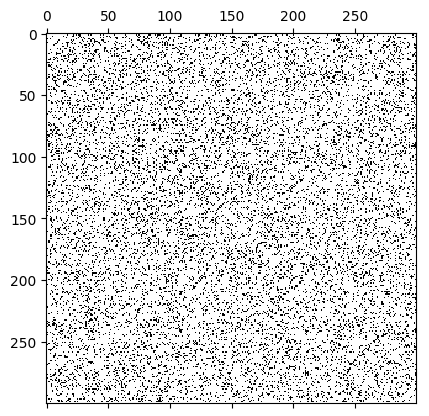

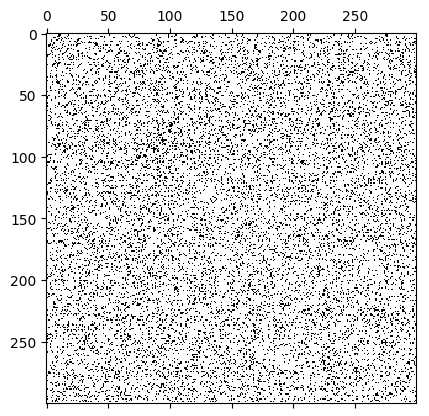

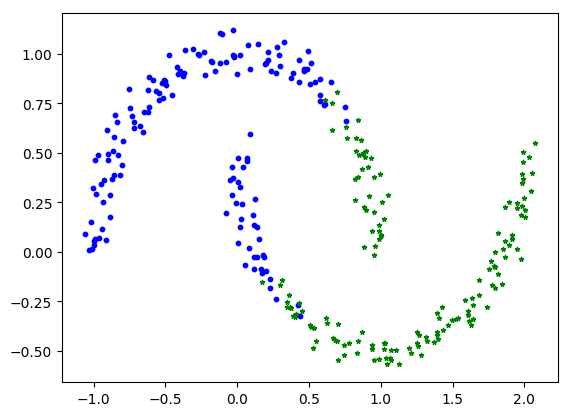

Array{Float64,2}


300×300 Array{Float64,2}:
 165.76        0.0        -0.986838  …    0.0         0.0         0.0     
   0.0       154.314      -0.696842      -1.53736     0.0         0.0     
  -0.986838   -0.696842  134.433         -1.42593     0.0         0.0     
  -1.76015     0.0         0.0            0.0         0.0        -1.39694 
   0.0         0.0         0.0           -1.67897     0.0        -0.615714
  -2.22459    -1.53318     0.0       …    0.0        -2.20581    -3.27354 
   0.0         0.0         0.0            0.0        -0.332004    0.0     
   0.0        -0.551801   -0.701469      -0.989684   -1.78086    -2.13592 
  -1.20271    -1.6236      0.0           -1.31515    -1.52818     0.0     
   0.0         0.0         0.0            0.0        -1.8792     -2.15217 
  -1.16361     0.0        -2.71342   …   -1.58122    -1.38586    -1.10643 
   0.0        -0.837817   -1.99275        0.0         0.0         0.0     
  -2.0384      0.0         0.0            0.0        -1.43668    -1.10551 

In [96]:
Lh = protocol(Ms_blackboard, Mk, X, "Two Moons")